In [5]:
import pandas as pd
from pmdarima.arima import auto_arima

In [2]:
data = pd.read_pickle('../data/df6_365.pkl')
data_arima = data[data['DATE'] > '2019-10-31']
data_arima = data_arima.drop(['YEAR_DAY',
                            'MEAN_CONSUMPTION',
                            'VARIANCE_CONSUMPTION',
                            'WEEKDAY',
                            'IS_WEEKEND',
                            'sin_WEEKDAY',
                            'cos_WEEKDAY',
                            'sin_year_day',
                            'cos_year_day',
                            'PRECIPITATIONS',
                            'MIN_TEMP',
                            'MEAN_TEMP',
                            'MAX_TEMP',
                            'SUN',
                            'IS_GOOD'], axis=1)

In [3]:
data_arima.head(5)

,ID,DELTA,DATE
273,0,502.0,2019-11-01
274,0,331.0,2019-11-02
275,0,307.0,2019-11-03
276,0,272.0,2019-11-04
277,0,289.0,2019-11-05


<AxesSubplot:xlabel='DATE'>

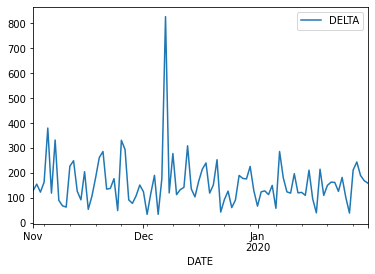

In [55]:
data_arima_prueba = data_arima[data_arima['ID'] == 14]
data_arima_prueba = data_arima_prueba.drop(['ID'], axis = 1)
data_arima_prueba.set_index('DATE', inplace = True)
data_arima_prueba.plot()

In [50]:
count = (data_arima_prueba['DELTA'] == 0).sum()
count

27

In [5]:
def selector_buenos_contadores_arima(dataframe, numero_dias_con_medida_0 = 10):
    '''
    Descripción: 
        Función que recibe un dataframe con información sobre mediciones de contadores y un umbral de días máximos en los que se admite tener
        lecturas de 0 y devuelve qué contadores son aptos para ARIMAS. 

    Inputs:
        dataframe (Pandas Dataframe): la última versión del dataframe de contadores limpiado, sin NAs, y con medidas diarias por filas.
        numero_dias_con_media_0 (int): umbral de dias con medida 0 que un contador puede tener como máximo para ser considerado bueno.

    Outputs:
        contadores_para_arima (list): lista con los identificadores de los contadores que se consideran buenos para ejecutar ARIMAS.

    '''
    contadores_para_arima = []
    for contador in range(0, len(dataframe['ID'].unique())):
        dataframe_objeto_analisis = dataframe[dataframe['ID'] == contador]
        if ((dataframe_objeto_analisis['DELTA'] == 0).sum()) <= numero_dias_con_medida_0:
            contadores_para_arima.append(contador)
    return contadores_para_arima

In [94]:
#Prueba
contadores_buenos = selector_buenos_contadores_arima(data_arima)
#Funciona

In [32]:
def arima_para_cada_contador(dataset_contadores, contadores, fecha = '2019-10-31'):
    dataset_a_estudiar = dataset_contadores[dataset_contadores['DATE'] > fecha]
    dataset_a_estudiar = dataset_a_estudiar.drop(['YEAR_DAY',
                                                    'MEAN_CONSUMPTION',
                                                    'VARIANCE_CONSUMPTION',
                                                    'WEEKDAY','IS_WEEKEND',
                                                    'sin_WEEKDAY',
                                                    'cos_WEEKDAY',
                                                    'sin_year_day',
                                                    'cos_year_day',
                                                    'PRECIPITATIONS',
                                                    'MIN_TEMP',
                                                    'MEAN_TEMP',
                                                    'MAX_TEMP',
                                                    'SUN',
                                                    'IS_GOOD'], axis=1)
    #Todas las predicciones en un dataframe
    dataframe_predicciones = dataset_a_estudiar[dataset_a_estudiar['ID'] == 0]
    dataframe_predicciones = dataframe_predicciones.drop(['ID', 'DELTA'], axis=1)
    dataframe_predicciones.set_index('DATE', inplace = True)
    for contador in contadores:
        contador_a_estudiar = dataset_a_estudiar[dataset_a_estudiar['ID'] == contador]
        #Drop ID
        contador_a_estudiar = contador_a_estudiar.drop(['ID'], axis=1)
        #Fechas a indices
        contador_a_estudiar.set_index('DATE', inplace = True)
        #MODELO POR CONTADOR
        train = contador_a_estudiar[:(92-14)]
        test = contador_a_estudiar[-14:]
        arima_model = auto_arima(train, 
                        start_p=0, 
                        d=1, 
                        start_q=0, 
                        max_p=7, 
                        max_d=7, 
                        max_q=7, 
                        start_P=0, 
                        D=1, 
                        start_Q=0, 
                        max_P=7, 
                        max_D=7, 
                        max_Q=7, 
                        m=12, 
                        seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        supress_warnings=True, 
                        stepwise=True, 
                        random_state=2517, 
                        n_fits=100)
        prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index = test.index)
        dataframe_predicciones[f'predict_cont_{contador}'] = prediction
    return(dataframe_predicciones)               

In [ ]:
dataframe_predicciones = arima_para_cada_contador(data, contadores_buenos)

In [ ]:
predicciones_enero.to_pickle('../data/predicciones_enero_arima.pkl')

In [6]:
preds_enero = pd.read_pickle('../data/predicciones_enero_arima.pkl')


In [7]:
preds_enero[preds_enero < 0] = 0

In [8]:
preds_enero

,predict_cont_0,predict_cont_2,predict_cont_3,predict_cont_4,predict_cont_6,predict_cont_7,predict_cont_9,predict_cont_14,predict_cont_15,predict_cont_16,...,predict_cont_349,predict_cont_351,predict_cont_352,predict_cont_353,predict_cont_355,predict_cont_357,predict_cont_359,predict_cont_360,predict_cont_363,predict_cont_364
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-18,365.249697,38.908300,477.114617,208.029711,119.301171,119.061093,77.299652,102.077328,220.311021,363.918567,...,270.501703,368.759607,441.679053,296.989608,10132.824838,352.462041,152.302406,1488.258936,216.689223,57.948454
2020-01-19,317.707626,38.098945,308.436727,234.396966,230.387642,57.580160,0.000000,140.181449,236.668265,245.429321,...,335.966337,307.027117,344.373215,0.000000,11590.263788,261.279874,217.138868,1608.462492,340.295658,63.470739
2020-01-20,372.683091,36.019619,333.502741,342.402486,271.001057,53.953736,0.000000,111.567599,201.257206,177.572112,...,306.968594,348.221067,354.238970,0.000000,11347.221089,263.549314,137.526998,1463.894187,396.741245,54.232895
2020-01-21,361.801828,46.344488,333.812113,168.588490,246.015492,21.274115,97.288928,137.954633,193.722387,171.402868,...,242.479729,275.178463,380.495273,0.000000,11692.636699,235.577684,202.369939,1551.241336,259.285011,43.255396
2020-01-22,271.285514,38.059881,421.190602,219.428458,206.920028,94.210617,0.000000,63.168955,289.802057,212.401321,...,313.268502,297.465137,403.679216,0.000000,11100.636250,230.889764,152.757931,2179.878972,274.443562,68.781203
2020-01-23,250.523312,34.178412,391.306287,258.231615,195.609386,20.689793,0.000000,173.492150,283.372695,205.199235,...,366.758176,369.619170,384.349366,345.757955,10560.713285,218.382430,159.160021,1881.970688,283.458127,41.889587
2020-01-24,272.933428,35.742352,349.186539,241.193862,258.664037,101.069058,33.675309,555.831090,331.052998,258.799414,...,340.747967,298.992852,400.902535,0.000000,10532.026751,227.321716,111.987227,1610.374761,266.620831,77.146833
2020-01-25,279.926453,33.129320,334.480909,214.654808,235.224625,85.213056,0.000000,99.807860,339.857038,196.678303,...,141.629030,259.369825,376.734343,0.000000,12084.845613,123.327692,156.158127,1433.475442,342.914883,48.279688
2020-01-26,332.993183,44.795888,345.231113,246.315880,219.144588,67.113818,0.000000,200.278265,490.851012,267.321265,...,280.095641,221.447446,389.825484,0.000000,11326.259396,231.232590,144.329735,1807.503372,267.368513,76.706051


In [15]:
preds_enero.to_pickle('../data/predicciones_enero_arima.pkl')

In [1]:
def compute_error(pred, real):
    daily_rmses = []
    for i in range(7):
        daily_rmses.append((((real.iloc[:,i] - pred.iloc[:,i])**2/len(real.iloc[:,i])).sum())**(1/2))
    rmse_1 = sum(daily_rmses)/7
    
    first_week_pred_sum = pred.iloc[:,7].sum()
    second_week_pred_sum = pred.iloc[:,8].sum()
    first_week_real_sum = real.iloc[:,7].sum()
    second_week_real_sum = real.iloc[:,8].sum()
    
    first_week_rmse = (((first_week_real_sum - first_week_pred_sum)**2)/len(real.iloc[:,7]))**(1/2)
    second_week_rmse = (((second_week_real_sum - second_week_pred_sum)**2)/len(real.iloc[:,8]))**(1/2)
    rmse_2 = (first_week_rmse + second_week_rmse)/2
    
    return (rmse_1 + rmse_2)/2

In [16]:
results_df = preds_enero.T
results_df.columns = [['Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7',
                       'Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14']]
results_df['Semana_1'] = results_df[['Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7']].sum(axis=1)
results_df['Semana_2'] = results_df[['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14']].sum(axis=1)
results_df.drop(['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14'], axis=1, inplace=True)
results_df

C:\Users\Manuel\AppData\Local\Temp/ipykernel_18948/3649680272.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  results_df.drop(['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14'], axis=1, inplace=True)


,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6,Dia_7,Semana_1,Semana_2
predict_cont_0,365.249697,317.707626,372.683091,361.801828,271.285514,250.523312,272.933428,2212.184497,2380.607964
predict_cont_2,38.908300,38.098945,36.019619,46.344488,38.059881,34.178412,35.742352,267.351996,277.591698
predict_cont_3,477.114617,308.436727,333.502741,333.812113,421.190602,391.306287,349.186539,2614.549625,2601.189993
predict_cont_4,208.029711,234.396966,342.402486,168.588490,219.428458,258.231615,241.193862,1672.271588,1399.899073
predict_cont_6,119.301171,230.387642,271.001057,246.015492,206.920028,195.609386,258.664037,1527.898813,1507.412879
...,...,...,...,...,...,...,...,...,...
predict_cont_357,352.462041,261.279874,263.549314,235.577684,230.889764,218.382430,227.321716,1789.462823,1638.467447
predict_cont_359,152.302406,217.138868,137.526998,202.369939,152.757931,159.160021,111.987227,1133.243391,1101.262303
predict_cont_360,1488.258936,1608.462492,1463.894187,1551.241336,2179.878972,1881.970688,1610.374761,11784.081372,10700.138673
predict_cont_363,216.689223,340.295658,396.741245,259.285011,274.443562,283.458127,266.620831,2037.533657,2179.282658


In [18]:
test = pd.read_pickle('../data/test.pkl')
test = test.head(365)

In [21]:
test

,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,first_week,second_week
ID,,,,,,,,,
0,421.00,273.0,306.00,292.00,460.00,331.00,368.00,2451.00,2222.00
1,0.00,216.0,14.00,3.00,0.00,3.00,5.67,241.67,54.33
2,28.00,33.0,48.00,35.00,33.00,20.00,37.00,234.00,272.00
3,485.00,394.0,237.00,297.00,312.00,321.00,439.00,2485.00,2792.00
4,365.00,387.0,370.00,293.00,287.00,361.00,203.00,2266.00,2216.00
...,...,...,...,...,...,...,...,...,...
360,1217.00,1193.0,2263.00,2451.00,2024.00,1339.00,2013.00,12500.00,11964.00
361,2.14,0.0,1.43,1.56,1.56,1.82,2.34,10.85,15.29
362,15.00,0.0,14.00,28.69,104.31,30.00,54.59,246.59,279.41


In [20]:
error = compute_error(results_df, test)
print('ARIMAS:', round(error,2))

ARIMAS: 25742.19
